## Traveling Assitant:
1. You need a specific experience but don't know how or where to get it?
2. You want to travel to a specific country but don't know where to visit?
3. You have a place in mind but don't know what it will cost?
This chatbot assistant is a personalized travel assistant. It makes recommendation, estimate real time cost, and help make reservations. (Future improvement to become an agent that books flight, make hotel reservation and dinning reservations).
4. After reaching a decision, saves the travel plan and itinerary to a pdf file for download.

### How to get real-time flight information
params = {
  "api_key": serpapi_key,
  "engine": "google_flights",
  "hl": "en",
  "gl": "us",
  "departure_id": "CDG",
  "arrival_id": "AUS",
  "outbound_date": "2025-02-07",
  "return_date": "2025-02-13",
  "currency": "USD"
}
1. get the IATA codes for the destination and arrival airports. LLM can provide this
2. get departure and arrival date

### incorporating Travel Guidance:
1. Booking flights: google flight serpapi
2. Accommodation: bookings.com
3. Getting around
4. planning itinerary


### ChatGPt plugins:
1. webpilot.ai

2. 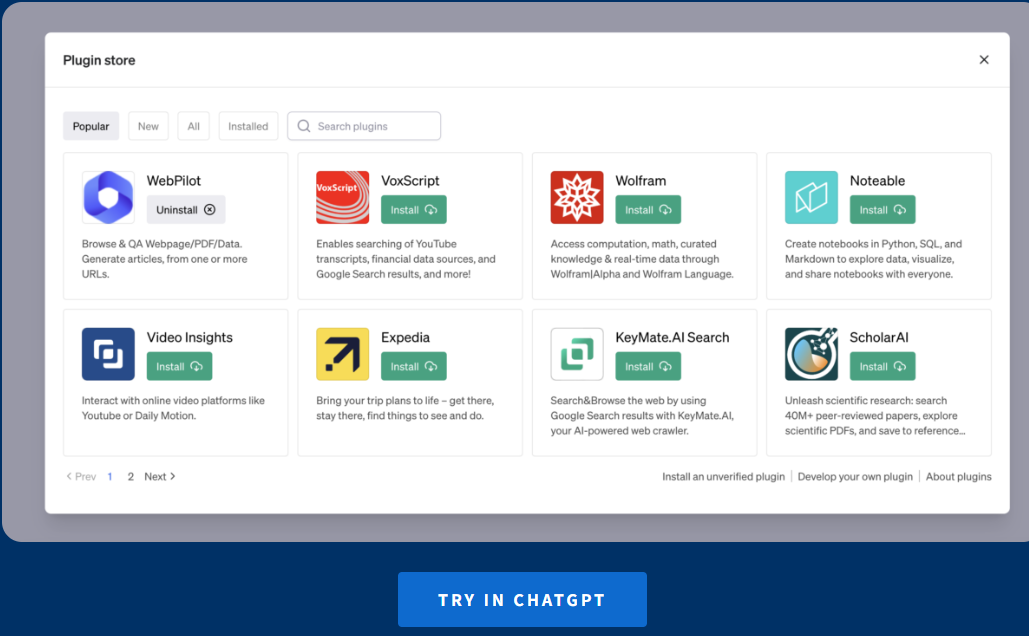


### Install dependencies

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
from serpapi import search
from datetime import datetime

# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

### Get APIs

In [2]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
serpapi_key = os.getenv('SERP_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
if serpapi_key:
    print(f"Serp API Key exists and begins {serpapi_key[:2]}")
else:
    print("SERP API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-
Serp API Key exists and begins b5


### Prompt Engineering: create an LLM prompt

In [3]:
system_message = "You are a helpful personal travel assistant"
system_message += "Help the user determine the experience they want to achieve from their travel."
system_message += "Suggest locations where they can have their desired experience."
system_message += "Provide real-time cost to travel."
system_message += "Provide guidance on how to travel to the desired location."
system_message += "Always be accurate. If you don't know the answer, say so."
system_message += "You should always be polite."
system_message += "Start a conversation by introducing yourself for example: 'Hi, I am Amy, your personal travel assistant.How may I help you?'."
system_message += f"Today's date is {datetime.today()}"

### Provide Chat interface: Launch on gradio

In [4]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

#gr.ChatInterface(fn=chat, type="messages").launch()

### Getting OpenAI to use Real-time flight data
1. We let the LLM know the tools we have, and when to use them.
2. The LLM informs us when it needs to use the tool.

#### TODOs:
1. how to cache an API call so the LLM can reference it during a conversation and does not make multiple API calls unnecessarily.
2. Add option for the customer to specify travel class e.g Businees, first or economy.
3. Add option for the customer to specify number of travelers.
4. Add option for the customer to specify flight type e.d direct
options = {   "travel_class": {
                "type": "string",
                "enum": ["economy", "business", "first"],
                "description": "The class of travel. Options are 'economy', 'business', or 'first'. Default is 'economy'.",
            },
            "num_passengers": {
                "type": "integer",
                "minimum": 1,
                "description": "The number of passengers traveling. Must be at least 1.",
            },
            "direct_flight": {
                "type": "boolean",
                "description": "Whether the customer prefers a direct flight. Default is False.",
            },
        },

In [5]:
# Function to fetch flight data from SerpAPI
from datetime import datetime
def get_flight_info(departure, arrival, departure_date, return_date):
    params = {
      "api_key": serpapi_key,
      "engine": "google_flights",
      "hl": "en",
      "gl": "us",
      "departure_id": departure,
      "arrival_id": arrival,
      "outbound_date": departure_date,
      "return_date": return_date,
      "currency": "USD"
    }
    # prevent past date from being sent to the api
    if datetime.strptime(departure_date, '%Y-%m-%d') < datetime.today():
        print("step1 failed")
        return []
    elif datetime.strptime(return_date, '%Y-%m-%d') < datetime.today():
        print("step2 failed")
        return []
    elif datetime.strptime(departure_date, '%Y-%m-%d') > datetime.strptime(return_date, '%Y-%m-%d'):
        print("step3 failed")
        return []
    else:
        flight_data = search(params)
        #flight_data = api_results
        flight_details = format_flight_data(flight_data)
        return flight_details

In [6]:
# Function to format flight data for display
def format_flight_data(flight_data):
    flights = flight_data.get("best_flights", [])
    if not flights:
        return "❌ No flights found. Try another date or route."

    all_flight_details = []
    
    for number, flight in enumerate(flights):
        flight_details = []
        price = f"💰 **Price**: ${flight['price']}\n"
        total_duration = f"⌛ **Total Flight Duration**: {flight['total_duration']} minutes\n"
        flight_type = f"🛫 **Type**: {flight['type']}\n"
        #layovers = f"🛬 **Layovers**: {flight['layovers']}\n"

        flight_details.append(price)
        flight_details.append(total_duration)
        flight_details.append(flight_type)
        #flight_details.append(layovers)

        sub_flights = flight['flights']
        for sub_flight in sub_flights:
            details = (
                f"✈️ **{sub_flight['airline']} {sub_flight['flight_number']}**\n"
                f"🛫 **Departure**: {sub_flight['departure_airport']['name']} ({sub_flight['departure_airport']['id']}) "
                f"at {sub_flight['departure_airport']['time']}\n"
                f"🛬 **Arrival**: {sub_flight['arrival_airport']['name']} ({sub_flight['arrival_airport']['id']}) "
                f"at {sub_flight['arrival_airport']['time']}\n"
                f"⌛ **Duration**: {sub_flight['duration']} minutes\n"
                f"💺 **Class**: {sub_flight['travel_class']}\n"
                f"✈️ **Aircraft**: {sub_flight['airplane']}\n"
                f"🌎 **Extras**: {', '.join(sub_flight['extensions']) if sub_flight['extensions'] else 'None'}\n"
                f"----------------------------"
            )
            flight_details.append(details)
            
        all_flight_details.append(f"✈️ Flight Option {number + 1}:\n" + "\n".join(flight_details))
    
    return "\n\n".join(all_flight_details)


In [7]:
# The particular dictionary structure that's required to describe our function for the LLM

flight_function = {
    "name": "get_flight_info",
    "description": "Get real-time information about a specific flight. Call this whenever you need to know the ticket price, for example, when a customer asks 'How much is a ticket to this city?'.\
    Call this whenever you need to know the flight details such as departure time, arrival time, available flights, flight route, duration of a flight, flight type, layovers, travel class, airplane, legroom, and extensions.",
    "parameters": {
        "type": "object",
        "properties": {
            "departure": {
                "type": "string",
                "description": "The IATA code of the airport the customer wants to travel from. For example, 'AUS' for Austin-Bergstrom International Airport.",
            },
            "destination": {
                "type": "string",
                "description": "The IATA code of the airport the customer wants to travel to. For example, 'JFK' for John F. Kennedy International Airport.",
            },
            "departure_date": {
                "type": "string",
                "format": "date",
                "description": "The date of departure in YYYY-MM-DD format. For example, '2024-06-15'.",
            },
            "return_date": {
                "type": "string",
                "format": "date",
                "description": "The return date in YYYY-MM-DD format for round trips. This field is optional.",
            },
    },
        "required": ["departure", "destination", "departure_date","return_date"],
        "additionalProperties": False,
}
}    


In [8]:
# create a dictionary that chat tool uses to  reqest for images. That is to interact with the image generator function
image_function = {
    "name": "image_generator",
    "description": "Get Pictures of travel destination. Call this whenever the customer request for images or pictures of a city, for example, when a customer asks 'How does Paris looks like?'.\
    Call this whenever you need to generate image of travel destination or vacation sites to explore.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "the name of a city",
            },
    },
    "required": ["city"],
    "additionalProperties": False,
}
} 

In [9]:
def chat(history):

    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    print(f"reason: {response.choices[0].finish_reason}\n")
    print(f"message: {response.choices[0].message}\n")
    print(f"content: {response.choices[0].message.content}\n")
    
    if response.choices[0].finish_reason=="tool_calls":
        # get the name of tool called
        message = response.choices[0].message
        tool_call = message.tool_calls[0]
        print(f"arguments: {json.loads(tool_call.function.arguments)}")
        arguments = json.loads(tool_call.function.arguments)
        tool_name = tool_call.function.name
        response = handle_tool_call(arguments, tool_name, tool_call)
        if tool_name == "get_flight_info":
            messages.append(message)
            messages.append(response)
        else:
            messages.append(message)
            messages.append(response)
            city = arguments.get('city')
            image = image_generator(city)

        response = openai.chat.completions.create(model=MODEL, messages=messages)
    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content":reply}]

    talker(reply)
    
    return history, image

In [10]:
# We have to write that function handle_tool_call:

def handle_tool_call(arguments, name, tool_call):
    if name == "get_flight_info":
        departure_code = arguments.get('departure')
        destination_code = arguments.get('destination')
        departure_date = arguments.get('departure_date')
        return_date = arguments.get('return_date')
        
        flight_details = get_flight_info(departure_code, destination_code, departure_date, return_date)
        response = {
            "role": "tool",
            "name": name,
            "content": json.dumps({"departure": departure_code, "destination": destination_code,\
                                   "departure_date":departure_date, "return_date": return_date,\
                                  "flight_details": flight_details}),
            "tool_call_id": tool_call.id
        }
        
    elif name == "image_generator":
        city = arguments.get('city')
        response = {
            "role": "tool",
            "name": name,
            "content": f"Here is an image representing {city}",  
            "tool_call_id": tool_call.id
        }
       
    else:
        print(f"Error: Unrecognized tool name '{name}'")
        return None  
    return response

### Going Multi modal: Generate images

In [11]:
def image_generator(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json", # return image as base64 json
        )

    # extract base64 image directly from OpenAI's response
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [12]:
# list of available tools for the LLM
tools = [{"type": "function", "function": flight_function}, {"type": "function", "function": image_function}]

### Going multi modal: insert audio

In [13]:
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

In [14]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
